1. Import necessary libraries and PORT-EK source code:

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import pathlib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from Bio import SeqIO, Align
from matplotlib import colormaps

#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())


444734


2. Declare data set specific definitions and functions:

In [2]:
# PORT-EK parameters
k = 11  # This is the length of k-mers
c = 0.05  # This is the conservation thershold used in k-mer rarity filter
m = 1  # This is the maximum number of mismatches allowed when re-examining rare k-mers
min_RMSE = 0.1  # This is the RMSE threshold used to select enriched k-mers

# Relative path to k-mer indices
INPUT_PATH = "../output/HIV/scenario4"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.
SAMPLE_GROUPS = ["M", "nonM"]
SAMPLE_SUBTYPE = ["MA","MB","MC","MD","Mrest","N","O","P"]
FREQ_COLS = [f"{group}_freq" for group in SAMPLE_GROUPS]
AVG_COLS = [f"{group}_avg" for group in SAMPLE_GROUPS]
ERR_COLS = []
P_COLS = []

VOLCANO_CMAP = {
    "not significant": ("#DDDDDD", 0.5),
    "M_enriched": ("#ffa401", 1),
    "nonM_enriched": ("#005ff5", 1),
}


def encode_kmer(kmer_seq: str) -> int:
    encoding_dict = {"A": "00", "C": "01", "G": "10", "T": "11"}
    kmer_bin_string = [encoding_dict[nuc] for nuc in kmer_seq]
    id = int("".join(kmer_bin_string), base=2)
    return id


def decode_kmer(id: int, k) -> str:
    decoding = {"00": "A", "01": "C", "10": "G", "11": "T"}
    kmer_bin_string = bin(id)[2:].rjust(2 * k, "0")
    kmer_bin_string = [
        kmer_bin_string[i : i + 2] for i in range(0, len(kmer_bin_string), 2)
    ]
    kmer_seq = "".join([decoding[bits] for bits in kmer_bin_string])
    return kmer_seq


def assign_kmer_type(row):
    if all(row[P_COLS] < 0.01):
        if max(row[AVG_COLS]) == row["M_avg"]:
            return "M_enriched"
        elif max(row[AVG_COLS]) == row["nonM_avg"]:
            return "nonM_enriched"
    else:
        return "not significant"

def check_exclusivity(row):
    if len([col for col in AVG_COLS if row[col] > 0]) == 1:
        return "exclusive"
    else:
        return "non-exclusive"

ref_seq = SeqIO.read("../input/HXB2.fasta", format="fasta").seq
aligner = Align.PairwiseAligner(
    match_score=5,
    mismatch_score=-4,
    open_gap_score=-10,
    extend_gap_score=-0.5,
    mode="local",
)

3. Construct k-mer count matrix and apply rarity filter

In [3]:
# First read all sample labels and k-mer sequences and construct an empty matrix. It requires significantly less memory than growing the matrix one-by-one.
kmer_set = set()
sample_list = []
kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*{k}mer_set.pkl")
sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")

for filename in kmer_set_in_path:
    with open(filename, mode="rb") as in_file:
        partial_set = pickle.load(in_file)
    kmer_set.update(partial_set)

for filename in sample_list_in_path:
    with open(filename, mode="rb") as in_file:
        partial_list = pickle.load(in_file)
    group = filename.stem.split("_")[0]
    partial_list = [f"M_{group}_{sample_name}" for sample_name in partial_list]

    sample_list.extend(partial_list)

all_kmer_matrix = pd.DataFrame(
    0, index=list(kmer_set), columns=sample_list, dtype="uint8"
)
group_sample_idx = {f"{group}": [sample for sample in sample_list if "M" in sample.split("_")[0]]  for group in SAMPLE_GROUPS}
subtype_sample_idx = {f"{subtype}": [sample for sample in sample_list if sample.split("_")[1] == f"{subtype}"] for subtype in SAMPLE_SUBTYPE}
print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")




Imported 1240578 kmers and 15295 samples.


In [5]:

# Next, fill the table with k-mer counts.
counter = 1
tot_files = len(sample_list)
in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_count.pkl")

for filename in in_path:
    with open(filename, mode="rb") as in_file:
        temp_dict = pickle.load(in_file)
    sample_name = "_".join(filename.stem.split("_")[:-1])
    print(sample_name)
    count_dict = {f"{sample_name}": temp_dict.values()}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    all_kmer_matrix.update(temp_df)
    print(
        f"Completed {filename.stem}. {counter} of {tot_files} indices done.",
        end="\r",
        flush=True,
    )
    counter += 1

# Decode k-mer sequences
all_kmer_matrix.index = all_kmer_matrix.index.map(lambda id: decode_kmer(id,k))

# Construct a temporary binary count matrix, i.e. one that shows if a k-mer is present in sequence, without regards to actual count.
# Calculate k-mer frequencies and average counts in host groups.
bin_kmer_matrix = all_kmer_matrix > 0
for group in SAMPLE_GROUPS:
    all_kmer_matrix[f"{group}_freq"] = bin_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
    all_kmer_matrix[f"{group}_avg"] = all_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
del bin_kmer_matrix

# Remove polyA, as its presence and count is mostly dependant on sequencing quality not viral variant.
if "AAAAAAAAAAA" in all_kmer_matrix.index:
    all_kmer_matrix = all_kmer_matrix.drop("AAAAAAAAAAA")

# Apply rarity filter.
common_kmer_matrix = portek.filter_kmers(
    all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c
)

print(
    f"\n{len(common_kmer_matrix)} common k-mers remaining after filtering at a threshold of {c}."
)

M_B.BR.2010.10BR_RJ042.KT427777
M_C.ZA.2007.CH212.PL.010807.UT.8.KY112092_count. 1 of 15295 indices done.
M_B.US.2019.p3t4_qvoa_cmv_well2.MW262776.8.KY112092_count. 2 of 15295 indices done.
M_B.US.2016.9252_wk12_5_O2.MW061553_well2.MW262776_count. 3 of 15295 indices done.
M_B.US.2005.USPI38417EI40y05051pcWG2B7.JN024367ount. 4 of 15295 indices done.
M_B.US.2016.VA40774.MK499378417EI40y05051pcWG2B7.JN024367_count. 5 of 15295 indices done.
M_B.US.2005.USPI38417EI83y05071pcWG2B8.JN024395 of 15295 indices done.
M_B.US.2008.CH302.PL.041608.A2.1.KY112127pcWG2B8.JN024395_count. 7 of 15295 indices done.
M_B.US.2016.9244_wk-2_6_D13.MW0612468.A2.1.KY112127_count. 8 of 15295 indices done.
M_B.US.2018.101-LN-5K20.MK1694566_D13.MW061246_count. 9 of 15295 indices done.
M_B.US.2014.PID7C-P6-O5-R.OQ953015MK169456_count. 10 of 15295 indices done.
M_B.US.2016.2274_EM_35.MZ922527O5-R.OQ953015_count. 11 of 15295 indices done.
M_B.US.2007.376JL2007P5D7.MK383569Z922527_count. 12 of 15295 indices done.
M_B.DE

KeyboardInterrupt: 

4. Calculate common k-mer statistics and identify host over-represented k-mers.

In [ ]:
# Calculate mean k-mer count change, RMSE and test statistical significance.
common_kmer_matrix["seq"] = common_kmer_matrix.index
ERR_COLS = []
P_COLS = []
for j in range(1, len(SAMPLE_GROUPS)):
    for i in range(j):
        err_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_err"
        p_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_p-value"
        ERR_COLS.append(err_name)
        P_COLS.append(p_name)
        common_kmer_matrix[err_name] = (
            common_kmer_matrix[f"{SAMPLE_GROUPS[i]}_avg"]
            - common_kmer_matrix[f"{SAMPLE_GROUPS[j]}_avg"]
        )
        common_kmer_matrix[p_name] = common_kmer_matrix["seq"].apply(
            portek.calc_kmer_pvalue,
            args=(
                group_sample_idx[SAMPLE_GROUPS[i]],
                group_sample_idx[SAMPLE_GROUPS[j]],
                common_kmer_matrix,
            ),
        )
        common_kmer_matrix[f"-log10_{p_name}"] = -np.log10(common_kmer_matrix[p_name])
common_kmer_matrix["RMSE"] = np.sqrt(((common_kmer_matrix[ERR_COLS]) ** 2).mean(axis=1))


common_kmer_matrix = common_kmer_matrix.sort_values("RMSE", ascending=False)
common_kmer_matrix = common_kmer_matrix.drop("seq", axis=1)

# Identify host-overrepresented k-mers, according to the statistics calculated above.
common_kmer_matrix["group"] = common_kmer_matrix.apply(
    assign_kmer_type,axis=1
)
common_kmer_matrix["exclusivity"] = common_kmer_matrix.apply(
    check_exclusivity, axis=1
)

# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)

# Record over-represented k-mers in separate DataFrames
M_overrep = common_kmer_matrix[common_kmer_matrix["group"] == "M_enriched"]
nonM_overrep = common_kmer_matrix[common_kmer_matrix["group"] == "nonM_enriched"]

Optional: save/load k-mer count and statistics matrices. Uncomment the relevant lines to save/load particular files.

In [ ]:
common_kmer_matrix.to_csv(f"../output/HIV/scenario1/common_{k}mer_count_matrix.csv")
common_kmer_stat_matrix.to_csv(f"../output/HIV/scenario1/common_{k}mer_stat_matrix.csv")
# all_kmer_matrix.to_csv(f"../output/HIV/scenario1/all_{k}mer_count_matrix.csv")

# common_kmer_matrix = pd.read_csv(f"../output/HIV/scenario1/common_{k}mer_count_matrix.csv", index_col=0)
# common_kmer_stat_matrix  = pd.read_csv(f"../output/HIV/scenario1/common_{k}mer_stat_matrix2.csv", index_col=0)
# all_kmer_matrix= pd.read_csv(f"../output/HIV/scenario1/all_{k}mer_count_matrix.csv", index_col=0)

5. Visualize common k-mers using volcano plots. Uncomment the last line in each cell to save as svg.

In [ ]:
fig, ax = plt.subplots()
plt.axhline(y=-np.log10(0.01), color = 'black')
ax.set_xlim(-1,1)
ax.set_title('Average kmer count change M vs nonM samples')
ax.set_xlabel('Average kmer count change')
ax.set_ylabel('-log10 of p-value')
sns.scatterplot(data=common_kmer_matrix, x='M-nonM_err', y = '-log10_M-nonM_p-value', s=10, linewidth = 0, hue='group', palette=VOLCANO_CMAP)
plt.show()

# plt.savefig("../output/HIV/scenario1/M_vs_nonM.svg", dpi = 600, format = "svg")

6. Optionally re-examin rare k-mers similar to over-represented k-mers. Run the two cells below only if you want to include potential rare, but still enriched k-mers in the analysis.

In [ ]:
# Select all rare k-mers that have higher average count in M, no matter the statistical significance.
M_overrep_rare = all_kmer_matrix.loc[
    (all_kmer_matrix["M_avg"] == all_kmer_matrix[AVG_COLS].max(axis=1))
]
M_overrep_rare = M_overrep_rare[~M_overrep_rare.index.isin(M_overrep.index)]

# Comment the following line to avoid lengthy k-mer similarity graph calculation
M_overrep_similarity_graph = portek.build_similarity_graph_two_list(
    M_overrep.index.tolist(), M_overrep_rare.index.tolist(), m
)

# Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

with open(f"../output/HIV/scenario1/mor_{k}mer_{m}m.pickle", mode = "wb") as out_file:
    pickle.dump(M_overrep_similarity_graph, out_file)

# with open(f"../output/HIV/scenario1/mor_{k}mer_{m}m.pickle", mode = "rb") as in_file:
#     M_overrep_similarity_graph = pickle.load(in_file)

# Discard rare k-mers that are not in the similarity graph.
M_overrep_rare = M_overrep_rare[
    M_overrep_rare.index.isin(M_overrep_similarity_graph.nodes)
]

# Calculate statistics and significance for rare k-mers similar to bat over-represented k-mers and choose the significant ones.
# Calculation is identical to the one done for common k-mers.
M_overrep_rare["M_err"] = M_overrep_rare["M_avg"] - M_overrep_rare["nonM_avg"]
M_overrep_rare["M_RMSE"] = np.sqrt(((M_overrep_rare["M_err"]) ** 2))
M_overrep_rare["seq"] = M_overrep_rare.index
M_overrep_rare["p-value"] = M_overrep_rare["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(M_sample_idx, nonM_sample_idx, M_overrep_rare),
)

M_overrep_rare = M_overrep_rare.sort_values("M_RMSE", ascending=False)
M_overrep_rare = M_overrep_rare.drop("seq", axis=1)
M_overrep_rare["-log10_p-value"] = -np.log10(M_overrep_rare["p-value"])
M_overrep_rare["group"] = M_overrep_rare.apply(assign_kmer_type, axis=1)
M_overrep_rare = M_overrep_rare[M_overrep_rare["group"] == "M over-represented"]
M_overrep_all = pd.concat([M_overrep_rare, M_overrep])

In [ ]:
# See cell above for explanation. This cell has the same calculations, but done on nonM over-represented k-mers.
nonM_overrep_rare = all_kmer_matrix.loc[
    (all_kmer_matrix["M_avg"] == all_kmer_matrix[AVG_COLS].min(axis=1))
]
nonM_overrep_rare = nonM_overrep_rare[~nonM_overrep_rare.index.isin(nonM_overrep.index)]

# Comment the following line to avoid lengthy k-mer similarity graph calculation
nonM_overrep_similarity_graph = portek.build_similarity_graph_two_list(
    nonM_overrep.index.tolist(), nonM_overrep_rare.index.tolist(), m
)

# Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

with open(f"../output/HIV/scenario1/nonmor_{k}mer_{m}m.pickle", mode = "wb") as out_file:
    pickle.dump(nonM_overrep_similarity_graph, out_file)

# with open(f"../output/HIV/scenario1/nonmor_{k}mer_{m}m.pickle", mode = "rb") as in_file:
#     nonM_overrep_similarity_graph = pickle.load(in_file)

nonM_overrep_rare = nonM_overrep_rare[
    nonM_overrep_rare.index.isin(nonM_overrep_similarity_graph.nodes)
]

nonM_overrep_rare["M_err"] = nonM_overrep_rare["M_avg"] - nonM_overrep_rare["nonM_avg"]
nonM_overrep_rare["M_RMSE"] = np.sqrt(((nonM_overrep_rare["M_err"]) ** 2))
nonM_overrep_rare["seq"] = nonM_overrep_rare.index
nonM_overrep_rare["p-value"] = nonM_overrep_rare["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(M_sample_idx, nonM_sample_idx, nonM_overrep_rare),
)

nonM_overrep_rare = nonM_overrep_rare.sort_values("M_RMSE", ascending=False)
nonM_overrep_rare = nonM_overrep_rare.drop("seq", axis=1)
nonM_overrep_rare["-log10_p-value"] = -np.log10(nonM_overrep_rare["p-value"])

nonM_overrep_rare["group"] = nonM_overrep_rare.apply(assign_kmer_type, axis=1)
nonM_overrep_rare = nonM_overrep_rare[
    nonM_overrep_rare["group"] == "nonM over-represented"
]
nonM_overrep_all = pd.concat([nonM_overrep_rare, nonM_overrep])

7. Find enriched k-mers by applying the RMSE filter. Export enriched k-mers for use in host classification.

In [ ]:
# Take the over-represented k-mers that pass the RMSE filter. This generates of enriched k-mers identified by PORT-EK.

# Uncomment this block if you didn't re-examine the rare k-mers.
M_enriched = M_overrep[M_overrep["RMSE"] > min_RMSE]
nonM_enriched = nonM_overrep[nonM_overrep["RMSE"] > min_RMSE]

# Comment this block if you didn't re-examine the rare k-mers.
# M_enriched = M_overrep_all[M_overrep_all['RMSE']>min_RMSE]
# nonM_enriched = nonM_overrep_all[nonM_overrep_all['RMSE']>min_RMSE]

# del all_kmer_matrix
enriched_kmer_matrix = pd.concat([M_enriched, nonM_enriched])
enriched_kmer_stat_martix = enriched_kmer_matrix.drop(sample_list, axis=1)

print(
    f"{len(M_enriched)} M enriched k-mers and {len(nonM_enriched)} non-M enriched k-mers found."
)


def assign_host_numerical(sample_id):
    if sample_id in group_sample_idx["M"]:
        host = 1
    else:
        host = 0
    return host


# Prepare and save count matrix with host labels for use by classifiers that predict the most probalbe host of a viral sequence.
counts_for_classifier = enriched_kmer_matrix.T
counts_for_classifier.drop(common_kmer_stat_matrix.columns.difference(['group']), axis=0, inplace=True)
counts_for_classifier['host'] = counts_for_classifier.index.map(assign_host_numerical)

counts_for_classifier.to_csv(f"../output/HIV/scenario1/{k}mer_counts_for_classifier.csv")
enriched_kmer_matrix.to_csv(f"../output/HIV/scenario1/enriched_{k}mer_count_matrix.csv")
enriched_kmer_stat_martix.to_csv(f"../output/HIV/scenario1/enriched_{k}mer_stat_matrix.csv")

In [5]:
enriched_kmer_matrix = pd.read_csv(f"../output/HIV/scenario1/enriched_{k}mer_count_matrix.csv", index_col=0)
enriched_kmer_stat_matrix = pd.read_csv(f"../output/HIV/scenario1/enriched_{k}mer_stat_matrix.csv", index_col=0)

8. Map enriched k-mers to the reference genome and identify host-enriched mutations.

In [7]:
ref_pos = []
matches = []

for i in range(len(enriched_kmer_matrix)):
    print(i, end="\r")
    alns = aligner.align(ref_seq, enriched_kmer_matrix.index[i])
    if len(alns) == 0:
        ref_pos.append("none")
        matches.append(0)
    else:
        matches.append([aln.counts()[1] for aln in alns])
        ref_pos.append(list(zip([aln.indices[0][0]+1 for aln in alns],[aln.indices[0][-1]+1 for aln in alns])))

enriched_kmer_matrix["ref_pos"] = ref_pos
enriched_kmer_matrix["matches"] = matches

/tmp/ipykernel_13461/2476684706.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  enriched_kmer_matrix["ref_pos"] = ref_pos
/tmp/ipykernel_13461/2476684706.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  enriched_kmer_matrix["matches"] = matches


In [11]:
kmer_coverage = pd.DataFrame(0, index=pd.RangeIndex(1,len(ref_seq)), columns=["M_enriched", "nonM_enriched"])

for kmer in enriched_kmer_matrix.index:
    group = enriched_kmer_matrix.loc[kmer, "group"]
    for position in enriched_kmer_matrix.loc[kmer, "ref_pos"]:
        kmer_coverage.loc[position[0]:position[1], group] += 1

In [12]:
kmer_coverage_long = pd.melt(kmer_coverage, ignore_index=False, var_name="group")

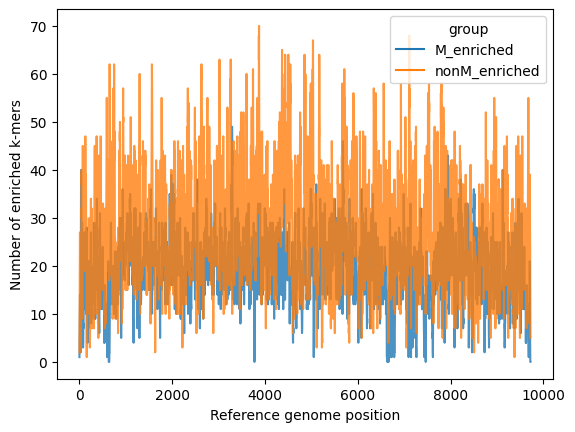

In [13]:
fig, ax = plt.subplots()
sns.lineplot(data = kmer_coverage_long, x=kmer_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Number of enriched k-mers")
for line in ax.lines:
    line.set_alpha(0.8)

plt.savefig(f"../output/HIV/scenario1/enriched_{k}mer_coverage.svg", format="svg", dpi=600)

In [14]:
enriched_kmer_matrix

,nonM_O.CM.1994.BCF06.AB485666,nonM_O.CM.1994.BCF06.AB485667,nonM_O.US.-.I_2478B.AB485668,nonM_O.US.-.I_2478B.AB485669,nonM_O.FR.1992.VAU.AF407418,nonM_O.SN.1999.99SE-MP1299.AJ302646,nonM_O.SN.1999.99SE-MP1300.AJ302647,nonM_O.CM.1998.98CMA104.AY169802,nonM_O.CM.1996.96CMA102.AY169803,nonM_O.CM.1998.98CMABB212.AY169804,...,nonM_freq,nonM_avg,M-nonM_err,M-nonM_p-value,-log10_M-nonM_p-value,RMSE,group,exclusivity,ref_pos,matches
GGAATTGGAGG,0,0,0,0,0,0,0,0,0,0,...,0.164384,0.164384,1.594649,3.486212e-51,50.457646,1.594649,M_enriched,non-exclusive,"[(2397, 2407), (4170, 4180)]","[11, 11]"
AAAACAAATTA,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,1.266128,1.875678e-54,53.726842,1.266128,M_enriched,exclusive,"[(4871, 4881), (7484, 7494)]","[11, 11]"
CAGGAAGATGG,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,1.249507,3.954537e-59,58.402904,1.249507,M_enriched,exclusive,"[(2368, 2378), (4543, 4553)]","[11, 11]"
TACAGTATTAG,0,0,0,0,0,0,0,0,0,0,...,0.068493,0.068493,1.234686,8.423879e-41,40.074488,1.234686,M_enriched,non-exclusive,"[(2342, 2352), (2471, 2481)]","[11, 11]"
CATCAAGCAGC,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,1.229733,1.939536e-46,45.712302,1.229733,M_enriched,exclusive,"[(1369, 1379), (7940, 7950)]","[11, 11]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGCATCTCATA,0,0,0,0,0,0,0,0,0,0,...,0.109589,0.109589,-0.100063,6.470905e-07,6.189035,0.100063,nonM_enriched,non-exclusive,"[(5960, 5970)]",[10]
ATCTCATATGG,0,0,0,0,0,0,0,0,0,0,...,0.109589,0.109589,-0.100063,6.470905e-07,6.189035,0.100063,nonM_enriched,non-exclusive,"[(5963, 5973)]",[10]
ACAACAAAATT,0,0,0,0,0,0,0,0,0,0,...,0.109589,0.109589,-0.100063,6.470905e-07,6.189035,0.100063,nonM_enriched,non-exclusive,"[(4881, 4896)]",[11]
TTATGTAGATA,0,0,0,0,0,0,0,0,0,0,...,0.123288,0.123288,-0.100032,5.504647e-05,4.259271,0.100032,nonM_enriched,non-exclusive,"[(3870, 3878)]",[9]


In [37]:
segemnt_coords = []
segment_colors = []
samples_to_plot = group_sample_idx["nonM"]
kmers_to_plot = enriched_kmer_matrix.loc[(enriched_kmer_matrix["exclusivity"] == "exclusive") & (enriched_kmer_matrix["group"] == "nonM_enriched")].index
y = 1
for sample_name in samples_to_plot:
    sample_group = [key for key,value in subtype_sample_idx.items() if sample_name in value][0]
    for kmer in kmers_to_plot:
        if enriched_kmer_matrix.loc[kmer, sample_name] > 0:
            temp_segments = enriched_kmer_matrix.loc[kmer, "ref_pos"]
            temp_segments = [((x1,y),(x2,y)) for x1,x2 in temp_segments]
            segemnt_coords.extend(temp_segments)
            segment_colors.extend([sample_group for _ in range(len(temp_segments))])
    y += 1

samples_to_plot = sample_list[74:1574]
kmers_to_plot = enriched_kmer_matrix.loc[(enriched_kmer_matrix["exclusivity"] == "exclusive") & (enriched_kmer_matrix["group"] == "M_enriched")].index
for sample_name in samples_to_plot:
    sample_group = [key for key,value in group_sample_idx.items() if sample_name in value][0]
    for kmer in kmers_to_plot:
        if enriched_kmer_matrix.loc[kmer, sample_name] > 0:
            temp_segments = enriched_kmer_matrix.loc[kmer, "ref_pos"]
            temp_segments = [((x1,y),(x2,y)) for x1,x2 in temp_segments]
            segemnt_coords.extend(temp_segments)
            segment_colors.extend([sample_group for _ in range(len(temp_segments))])
    y += 1


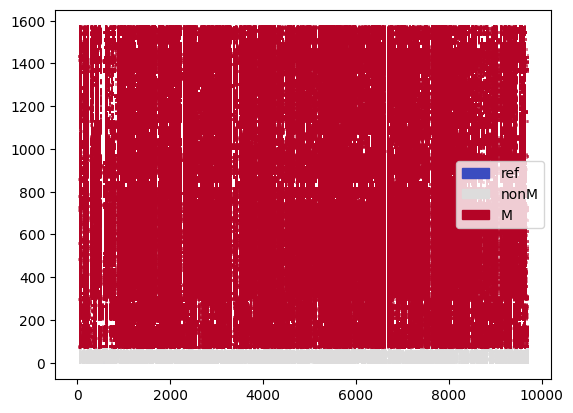

In [38]:
portek.plot_segments_by_genome(segemnt_coords, segment_colors, ref_seq)

In [ ]:
portek.plot_segments(aligned_M_enriched_kmers, ref_seq)
portek.plot_segments(aligned_nonM_enriched_kmers, ref_seq)

In [ ]:
aligned_M_enriched_kmer_graph = portek.assemble_kmers(aligned_M_enriched_kmers.index, kmer_df=aligned_M_enriched_kmers)
aligned_nonM_enriched_kmer_graph = portek.assemble_kmers(aligned_nonM_enriched_kmers.index, kmer_df=aligned_nonM_enriched_kmers)

In [ ]:
contigs = {"group":[],"ref_start":[], "ref_end":[], "seq":[]}

assemblies = [aligned_M_enriched_kmer_graph.subgraph(c).copy() for c in nx.weakly_connected_components(aligned_M_enriched_kmer_graph)]
for assembly in assemblies:
        sources = [node for node in assembly.nodes if assembly.in_degree(node) == 0]
        targets = [node for node in assembly.nodes if assembly.out_degree(node) == 0]
        paths = []
        for source in sources:
            for target in targets:
                if nx.has_path(assembly, source, target):
                    paths.extend(list(nx.all_simple_paths(assembly, source, target, cutoff=cutoff)))
        for path in paths:
            contigs["group"].append("M_enriched")
            contigs["ref_start"].append(aligned_enriched_kmers.loc[path[0], "ref_start"])
            contigs["ref_end"].append(aligned_enriched_kmers.loc[path[-1], "ref_end"])
            seq = "".join([path[0]] + [kmer[-1] for kmer in path[1:]])
            contigs["seq"].append(seq)

assemblies = [aligned_nonM_enriched_kmer_graph.subgraph(c).copy() for c in nx.weakly_connected_components(aligned_nonM_enriched_kmer_graph)]
for assembly in assemblies:
        sources = [node for node in assembly.nodes if assembly.in_degree(node) == 0]
        targets = [node for node in assembly.nodes if assembly.out_degree(node) == 0]
        paths = []
        for source in sources:
            for target in targets:
                if nx.has_path(assembly, source, target):
                    paths.extend(list(nx.all_simple_paths(assembly, source, target, cutoff=cutoff)))
        for path in paths:
            contigs["group"].append("nonM_enriched")
            contigs["ref_start"].append(aligned_enriched_kmers.loc[path[0], "ref_start"])
            contigs["ref_end"].append(aligned_enriched_kmers.loc[path[-1], "ref_end"])
            seq = "".join([path[0]] + [kmer[-1] for kmer in path[1:]])
            contigs["seq"].append(seq)

contigs  = pd.DataFrame(contigs).sort_values("ref_start")
real_seq = list(SeqIO.parse("../input/HIV/prepped/M.fasta", format = "fasta"))+list(SeqIO.parse("../input/HIV/prepped/nonM.fasta", format = "fasta"))
contigs["is_real"] = 0
for i in range(len(contigs)):
    is_real = 0
    for seq in real_seq:
        if contigs.loc[i, "seq"] in seq.seq:
            is_real = 1
            break
    contigs.loc[i, "is_real"] = is_real
contigs = contigs[contigs["is_real"] == 1].drop("is_real", axis=1)

In [ ]:
portek.plot_segments(contigs, ref_seq)

In [ ]:
M_enriched_graph = portek.assemble_kmers(unaligned_enriched_kmers[unaligned_enriched_kmers["group"] == "M_enriched"].index, how="seq")
nonM_enriched_graph = portek.assemble_kmers(unaligned_enriched_kmers[unaligned_enriched_kmers["group"] == "nonM_enriched"].index, how="seq")

In [ ]:
assemblies = [nonM_enriched_graph.subgraph(c).copy() for c in nx.weakly_connected_components(nonM_enriched_graph)]
contigs = {"group":[],"seq":[],"len":[]}
cutoff = len(ref_seq)-k+1
for assembly in assemblies:
    # if nx.is_directed_acyclic_graph(assembly) == True:
        sources = [node for node in assembly.nodes if assembly.in_degree(node) == 0]
        targets = [node for node in assembly.nodes if assembly.out_degree(node) == 0]
        # if len(sources) == 1:
        paths = []
        for source in sources:
            for target in targets:
                if nx.has_path(assembly, source, target):
                    paths.extend(list(nx.all_simple_paths(assembly, source, target, cutoff=cutoff)))
        for path in paths:
            contigs["group"].append("nonM_enriched")
            seq = "".join([path[0]] + [kmer[-1] for kmer in path[1:]])
            contigs["seq"].append(seq)
            contigs["len"].append(len(seq))


assemblies = [M_enriched_graph.subgraph(c).copy() for c in nx.weakly_connected_components(M_enriched_graph)]
for assembly in assemblies:
    # if nx.is_directed_acyclic_graph(assembly) == True:
        sources = [node for node in assembly.nodes if assembly.in_degree(node) == 0]
        targets = [node for node in assembly.nodes if assembly.out_degree(node) == 0]
        # if len(sources) == 1:
        paths = []
        i=1
        for source in sources:
            for target in targets:
                if nx.has_path(assembly, source, target):
                    paths.extend(list(nx.all_simple_paths(assembly, source, target, cutoff=cutoff)))

        for path in paths:
            contigs["group"].append("M_enriched")
            seq = "".join([path[0]] + [kmer[-1] for kmer in path[1:]])
            contigs["seq"].append(seq)
            contigs["len"].append(len(seq))


contigs = pd.DataFrame(contigs)

starts = []
ends = []
matches = []

for i in range(len(contigs)):
    alns = aligner.align(ref_seq, contigs.loc[i,"seq"])
    if len(alns) == 0:
        starts.append("none")
        ends.append("none")
        matches.append(0)
    elif len(alns) > 1:
        starts.append("multiple")
        ends.append("multiple")
        matches.append(0)
    else:
        for aln in alns:
            matches.append(aln.counts()[1])
            starts.append(aln.indices[0][0]+1)
            ends.append(aln.indices[0][-1]+1)


contigs["ref_start"] = starts
contigs["ref_end"] = ends
contigs["matches"] = matches

contigs = contigs[contigs["ref_start"] != "multiple"].sort_values("ref_start")
contigs